In [ ]:
# an attempt on Actor-Critic A2C
# not part of the project as I haven't figured out the correct backpropagation

# code modified from
# https://github.com/pytorch/examples/blob/master/reinforcement_learning/actor_critic.py

In [ ]:
# TODO
# - implement it
# - test whether sharing first layers help improving performance

In [36]:
%load_ext autoreload
%autoreload 2

import gc
import random
import numpy as np
import pandas as pd
import axelrod as axl
from time import time
from pprint import pprint
import matplotlib.pyplot as plt
from itertools import permutations
from collections import namedtuple, deque

np.set_printoptions(precision=3)
pd.options.display.float_format = "{:,.2f}".format

import network
from axl_utils import NNplayer, State, set_match, set_play

In [37]:
C = axl.Action.C
D = axl.Action.D

# config game rules
GAME_LEN = 20
GAME = axl.Game(r=3, s=0, t=5, p=1)
Match = set_match(game=GAME, turns=GAME_LEN)
play = set_play(Match)

game = play(axl.Prober4(), axl.TitForTat())

[(3, 3), (3, 3), (5, 0), (0, 5), (5, 0), (1, 1), (1, 1), (0, 5), (3, 3), (5, 0), (0, 5), (5, 0), (0, 5), (3, 3), (5, 0), (0, 5), (5, 0), (1, 1), (0, 5)]
Player 1 score = 45
Player 2 score = 45


In [38]:
Transition = namedtuple('Transition', 
                        ('state', 'action', 'next_state', 'reward'))

class NNplayer(axl.Player):
    """
    
    """
    
    name = 'NNplayer'
    classifier = {
        'memory_depth': -1,
        'stochastic': False,
        'inspects_source': False,
        'manipulates_source': False,
        'manipulates_state': False
    }
    
    decision = (axl.Action.C, axl.Action.D)
    
    def __init__(self, network, state, reward='dense', policy='off', name='DQN'):
        super().__init__()
        
        self.name    = name
        self.state   = state
        self.network = network
        
        self.policy_mode = True if policy=="off" else False      # off-policy = 1, on-policy = 0
        self.reward_mode = True if reward=="dense" else False    # dense reward = 1, sparse reward = 0
        self.N = self.state.N                                    # how not-yet-happened turn is encoded
        self.reset()
    
    def __str__(self):
        return self.name
    
    # the following 3 functions override the orginal implementation in axelrod library
    # they are automatically called by axl during each game
    def reset(self):
        """Reset the attributes to start a new game"""
        self.reward = 0
        self.state.reset()
        self.transitions = []
        self.network.reset_state()
        self._history = axl.history.History()
        
    def strategy(self, opponent):
        """Query the network (each turn) to make decision"""
        idx = self.network.query(self.state.values())
        return self.decision[idx]
    
    # overwrite update_history to update our state
    def update_history(self, *args):
        self.history.append(*args)
        self.update_state(*args)
    # --------------------------------------------------------------------------------
        
    def update_state(self, play, coplay):
        """Update current game state & record transition into replay memory
        
        Parameters
        ----------
        play : axl.Action
            action from last turn, (C or D)
        coplay: axl.Action
        
        """
        
        # update game state
        s  = self.state.values()
        s_ = self.state.push(play, coplay)
        last_turn = s[0,0,1]!=self.N
        
        # compute reward
        r  = axl.interaction_utils.compute_scores([(play, coplay)])[0][0]
        
        # rewrite action
        action = [True, False] if play==axl.Action.C else [False, True]
        
        # dense reward
        if self.reward_mode:
            r  = r if (not last_turn or not self.policy_mode) else np.NaN  # set last turn reward to NaN (off-policy only)
            transition = Transition(s, action, s_, r)
        
        # sparse reward
        else:
            if not last_turn:
                transition = Transition(s, action, s_, 0)
                self.reward += r
            else:
                transition = Transition(s, action, s_, r+self.reward)
                self.reward = 0
        
        # record transitions for training
        self.transitions.append(transition)
        
        # last turn operations
        if last_turn:
            self.end_episode()
    
    def end_episode(self):
        # for off-policy learner,
        # push all transitions into replay memory
        if self.policy_mode:
            for t in self.transitions:
                self.network.push(t)
            self.transitions = []

        # for on-policy learner,
        # push all rewards,
        # then call train function
        else:
            for t in self.transitions:
                self.network.push(t.reward)
            self.transitions = []
            self.network.train()
    
    
    def train(self, *args, **kwargs):
        self.network.train(*args, **kwargs)
    
    def plot(self, **kwargs):
        """Let the network plot its training loss"""
        self.network.plot(**kwargs)

    # test mode using "with" statement
    def __enter__(self, *args):
        self.network.test_mode(True)
    
    def __exit__(self, *args):
        self.network.test_mode(False)
    
    def set_greedy(self, value):
        self.network.greedy = value

In [39]:
from random import sample

In [220]:
class A2C():
    
    def __init__(self, actor, critic, gamma=0.99):
        """
        Initialize the actor critic network,
        
        Arguments
        -------
        actor : network object
            policy network, output 1xN array (action probabilities)
        
        critic : network object
            value network, output 1x1 array (estimated state value)
        
        (optional) gamma : float
            future discount rate, default = 0.9
        """
        self.losses = []
        self.actor  = actor
        self.critic = critic
        self.gamma  = gamma
        self.verbose = False
        self._test_mode = False
        
        self.reset_state()
    
    def set_param(self, a_param, c_param):
        """
        Set up optimizers etc.
        
        Arguments
        -------
        param: dict
            hyperparameters
        """
        self.param = (a_param, c_param)
        self.actor.set_up(a_param)
        self.critic.set_up(c_param)
    
    def reset_state(self):
        """Clean memory for new episode"""
        self.saved_actions = []  # [(log_prob(chosen action), state_value)]
        self.saved_rewards = []  # [reward from environment]
        
    def push(self, reward):
        """Push one reward value into memory"""
        self.saved_rewards.append(reward)
        
    def forward(self, state):
        """
        Forward thru neural network,
        
        Arguments
        -------
        state : ndarray
            input to the network
        
        
        Returns
        -------
        probs: ndarray, of dimension 1x[N actions]
            probability of actions by actor
            
        value: ndarray, of dimension 1x1
            estimated value of the state by critic
        """
        probs = self.actor(state)[0]
        value = self.critic(state)   
        return probs, value
    
    def __call__(self, *args):
        return self.forward(*args)
    
    def query(self, state):
        """Query for action, chosen action & its probability is saved for training
        
        Arguments
        -------
        state : ndarray
            numerical representation of the environment
        """
        probs, value = self.forward(state)
        
        # for test mode, output probabilities then choose action deterministically
        if self._test_mode:
            print(probs, value)
            return probs.argmax()
        
        # otherwise choose action with given probability
        else:
            # sample action
            cum_probs = np.cumsum(probs)
            action = (cum_probs > np.random.uniform()).argmax()  # Int index of action

            # save
            action2 = np.array([1, 0]) if action==0 else np.array([0,1]) # CHANGE ACTION SPACE TO PLAY OTHER GAMES
            self.saved_actions.append((action2, np.log(probs[action]), value))  # (1xn array, 1x1 array, 1x1 array)  

            return action
    
    def train(self):
        """
        Train the network, should be called after each game,
        hyperparameters should be given before calling this function (via set_param)
        """
        
        # avoid training under test mode
        if self._test_mode:
            return

        assert self.param, """Hyperparameters not configured yet"""
        
        if self.verbose:
            print(self.saved_actions)
            print(self.saved_rewards)
        
        policy_losses = []
        value_losses = []
        
        # last turn
        (action, log_prob, pred_v) = self.saved_actions[-1]
        target = self.saved_rewards[-1]
        advantage = target - pred_v

        policy_losses.append(-log_prob * advantage * action)
        value_losses.append(advantage)
        pred_v_next = pred_v
        
        # init turns
        for (action, log_prob, pred_v), reward in zip(self.saved_actions[-2::-1], self.saved_rewards[-2::-1]):

            # regression target = r + y * Vs+1
            target = reward + self.gamma * pred_v_next
            advantage = target - pred_v
            
            policy_losses.append(-log_prob * advantage * action)
            value_losses.append(advantage)

            pred_v_next = pred_v

        if self.verbose:
            print("\npolicies:")
            print(policy_losses)
            print("\nvalues:")
            print(value_losses)

        # sum all losses then feedback to networks
        policy_losses = sample(policy_losses, 5)
        value_losses = sample(value_losses, 5)
        policy_loss = np.array([i[0] for i in policy_losses]).sum(axis=0, keepdims=True)
        value_loss  = np.array(np.sum(value_losses))
        
        
        if self.verbose:
            print("\npolicy:")
            print(policy_loss)
            print("\nvalue:")
            print(value_loss)
        
        self.actor.backprop(policy_loss, self.param[0])
        self.critic.backprop(value_loss, self.param[1])

        #self.running_loss
        self.losses.append((policy_loss, value_loss))

        # clean memory
        self.reset_state()
        self.actor.reset_moments()
        self.critic.reset_moments()
        
    def test_mode(self, on):
        """Turn on test mode"""
        if on:
            self._test_mode = True
        else:
            self._test_mode = False
            
    def plot(self):
        pass

In [221]:
#layer1 = [network.Flatten_layer(), network.Linear_layer(20*2, 100)]

actor = network.NeuralNetwork([
                    network.Flatten_layer(), network.Linear_layer(GAME_LEN*2, 100),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(100, 40),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(40, 2),
                    network.Activation_layer('Fast_Softmax')
                    ])
critic = network.NeuralNetwork([
                    network.Flatten_layer(), network.Linear_layer(GAME_LEN*2, 100),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(100, 200),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(200, 1),
                    ])

nn = A2C(actor, critic, gamma=0.99)
p1 = NNplayer(nn, State(20, C=1, D=0.1, N=-1), policy='on')

del actor, critic
gc.collect()

81

In [222]:
with p1:
    m = axl.Match((p1, axl.TitForTat()), turns=20)
    m.play();
m.scores()

[0.782 0.218] [[-0.426]]
[0.94 0.06] [[-1.041]]
[0.843 0.157] [[-0.059]]
[0.438 0.562] [[0.116]]
[0.623 0.377] [[-0.539]]
[0.644 0.356] [[-1.164]]
[0.472 0.528] [[-0.097]]
[0.274 0.726] [[-0.562]]
[0.157 0.843] [[-1.597]]
[0.047 0.953] [[-1.758]]
[0.047 0.953] [[-0.075]]
[0.117 0.883] [[-0.156]]
[0.186 0.814] [[0.156]]
[0.435 0.565] [[-0.104]]
[0.471 0.529] [[1.092]]
[0.097 0.903] [[0.778]]
[0.129 0.871] [[1.586]]
[0.876 0.124] [[1.05]]
[0.916 0.084] [[-0.068]]
[0.371 0.629] [[0.057]]


[(3, 3),
 (3, 3),
 (3, 3),
 (5, 0),
 (0, 5),
 (3, 3),
 (5, 0),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (0, 5),
 (3, 3),
 (5, 0)]

In [223]:
ITERATIONS = 2000
a_param = {"lr": 5e-5, 'batch': GAME_LEN, "mode": "train", "eps": 1e-16, "epoch": 0, 't': 1, 'clip': 1.0,
         'optimizer': ('Adam', 0.9, 0.999), 'regularizer': ('l1', 1e-3), "loss_fn":"fast_cross_entropy"}
c_param = {"lr": 5e-5, 'batch': GAME_LEN, "mode": "train", "eps": 1e-16, "epoch": 0, 't': 1, 'clip': 1.0,
         'optimizer': ('Adam', 0.9, 0.999), 'regularizer': ('l1', 1e-3), "loss_fn":"mse"}
p1.network.set_param(a_param, c_param)

In [224]:
for i in range(ITERATIONS):
    # play against tit-for-tat
    # training function is called after each game internally
    m = axl.Match((p1, axl.TitForTat()), turns=20)
    m.play();

In [225]:
with p1:
    m = axl.Match((p1, axl.TitForTat()), turns=20)
    m.play();
m.scores()

[0.762 0.238] [[-5.434]]
[0.919 0.081] [[-6.407]]
[0.796 0.204] [[-5.889]]
[0.622 0.378] [[-7.44]]
[0.717 0.283] [[-8.518]]
[0.683 0.317] [[-8.219]]
[0.79 0.21] [[-9.859]]
[0.808 0.192] [[-12.016]]
[0.914 0.086] [[-14.522]]
[0.962 0.038] [[-17.161]]
[0.997 0.003] [[-20.51]]
[9.999e-01 1.377e-04] [[-22.904]]
[1.000e+00 3.061e-07] [[-27.425]]
[1.000e+00 1.438e-10] [[-37.591]]
[1.000e+00 2.342e-13] [[-46.866]]
[1.000e+00 2.706e-14] [[-54.96]]
[1.000e+00 6.268e-17] [[-60.279]]
[1.000e+00 1.221e-20] [[-72.606]]
[1.000e+00 4.003e-23] [[-84.609]]
[1.000e+00 7.969e-25] [[-93.775]]


[(3, 3),
 (3, 3),
 (3, 3),
 (3, 3),
 (3, 3),
 (3, 3),
 (3, 3),
 (3, 3),
 (3, 3),
 (3, 3),
 (3, 3),
 (3, 3),
 (3, 3),
 (3, 3),
 (3, 3),
 (3, 3),
 (3, 3),
 (3, 3),
 (3, 3),
 (3, 3)]

In [226]:
p1.network.verbose = True
m = axl.Match((p1, axl.TitForTat()), turns=20)
m.play();
m.scores()
p1.network.verbose = False

[(array([1, 0]), -0.2711907407289628, array([[-5.434]])), (array([1, 0]), -0.08446445846714462, array([[-6.407]])), (array([1, 0]), -0.22808799213607603, array([[-5.889]])), (array([1, 0]), -0.47541826630900225, array([[-7.44]])), (array([0, 1]), -1.2611946707684694, array([[-8.518]])), (array([1, 0]), -0.5995890026167243, array([[-7.08]])), (array([1, 0]), -0.3082027230968933, array([[-8.972]])), (array([1, 0]), -0.3716545403134899, array([[-10.768]])), (array([1, 0]), -0.11839143005281372, array([[-13.014]])), (array([1, 0]), -0.09939467208868892, array([[-14.918]])), (array([1, 0]), -0.029275050867294528, array([[-18.171]])), (array([1, 0]), -0.0008174734523613326, array([[-19.699]])), (array([1, 0]), -1.9229176472850944e-06, array([[-25.302]])), (array([1, 0]), -6.481073457788818e-10, array([[-36.756]])), (array([1, 0]), -1.7905676941170555e-12, array([[-43.059]])), (array([1, 0]), -2.4158453015846324e-13, array([[-50.155]])), (array([1, 0]), 0.0, array([[-57.186]])), (array([1, 0]

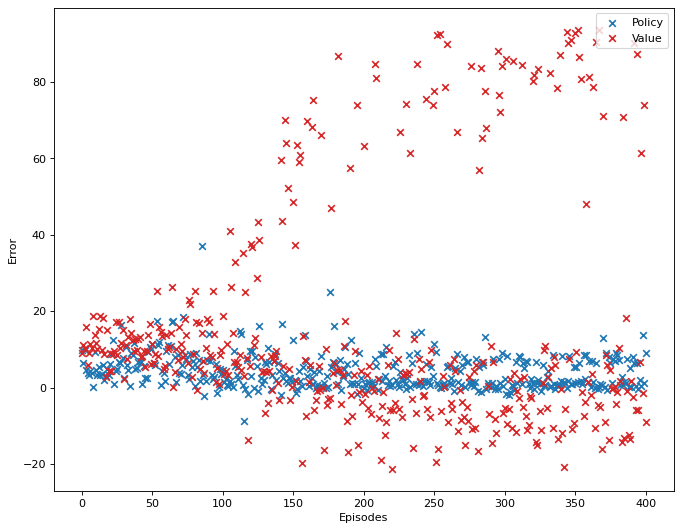

In [227]:
x0 = list(zip(*p1.network.losses[::5]))[0]
x0 = np.sum(x0, axis=2).T[0]
x1 = list(zip(*p1.network.losses[::5]))[1]

plt.figure(figsize=(10, 8), dpi=80)
plt.scatter(range(len(x0)), x0, c='tab:blue', marker='x', label='Policy')
plt.scatter(range(len(x1)), x1, c='tab:red', marker='x', label='Value')
plt.xlabel('Episodes')
plt.ylabel('Error')
plt.legend(loc='upper right')